## Global sensitivity analysis of the spinning dust SED features to the grain and environmental parameters.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from matplotlib.colors import to_rgba
import warnings
warnings.filterwarnings('ignore')

# Add the root directory of the package to sys.path
sys.path.append('/Users/zzhang/Workspace/SpyDust/')
sys.path.append('../')

In [2]:
# Configure matplotlib for publication quality
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'Bitstream Vera Serif', 'serif'],
    'text.usetex': False,  # Set to True if LaTeX is available
    'figure.figsize': [10, 8],
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.format': 'pdf',
    'axes.linewidth': 1.2,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'lines.markersize': 6
})

In [3]:
# Check which font is actually being used
import matplotlib.font_manager as fm
font_prop = fm.FontProperties(family='serif')
print(f"Active serif font: {font_prop.get_name()}")
print(f"Available serif fonts: {[f.name for f in fm.fontManager.ttflist if 'serif' in f.name.lower()][:5]}")  # Show first 5

Active serif font: Times New Roman
Available serif fonts: ['DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif Display', 'DejaVu Serif']


In [4]:
# Import SpyDust modules
import functools
import SpyDust.Grain as Grain
from SpyDust.SpyDust import SpyDust_given_grain_size_shape
from SpyDust.util import makelogtab, cgsconst
from SpyDust.SPDUST_as_is import emissivity
import matplotlib.cm as cm


l_a computed
readPAH computed
Loaded previously computed Jpeisrf arrays from file.
Tev table already exists at /Users/zzhang/Workspace/SpyDust/SpyDust/Data_Files/Tev_30a_30chi.txt.
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
Gaunt factor stored
l_a computed
readPAH computed
Loaded previously computed Jpeisrf arrays from file.
Maximum energy in the Qabs_hnu_tab is 1239.84 eV.
FIR_integral_charged shape: (30, 30)
Na: 30, Nchi: 30
Tev table already exists at /Users/zzhang/Workspace/SpyDust/SpyDust/Data_Files/Tev_30a_30chi.txt.
Gaunt factor stored


In [5]:
freqs = np.loadtxt('data/freq.txt')
HII_params = np.loadtxt('data/HII_params.txt')
HII_sed_tumbling = np.loadtxt('data/HII_SED_tumbling.txt')
# HII_sed_no_tumbling = np.loadtxt('data/HII_SED_no_tumbling.txt')

# Remove unphysical SEDs (nan or negative values)
valid_indices_tumbling = ~np.isnan(HII_sed_tumbling).any(axis=1) & (HII_sed_tumbling > 0).all(axis=1)
HII_sed_tumbling = HII_sed_tumbling[valid_indices_tumbling]
HII_params_tumbling = HII_params[valid_indices_tumbling]

# valid_indices_no_tumbling = ~np.isnan(HII_sed_no_tumbling).any(axis=1) & (HII_sed_no_tumbling > 0).all(axis=1)
# HII_sed_no_tumbling = HII_sed_no_tumbling[valid_indices_no_tumbling]
# HII_params_no_tumbling = HII_params[valid_indices_no_tumbling]

from SpyDust.SED_fit import fit_sed_ensemble

HII_features_tumbling = fit_sed_ensemble(
    freqs,
    HII_sed_tumbling,
    thres=1e-3, 
    v2=False
)
HII_features_tumbling[:,0] = np.exp(HII_features_tumbling[:,0])  # Convert log(nu_peak) to nu_peak

# HII_features_no_tumbling = fit_sed_ensemble(
#     freqs,
#     HII_sed_no_tumbling,
#     thres=1e-3, 
#     v2=False
# )
# HII_features_no_tumbling[:,0] = np.exp(HII_features_no_tumbling[:,0])  # Convert log(nu_peak) to nu_peak

100%|██████████| 100000/100000 [00:16<00:00, 6116.60it/s]


In [6]:
HII_catalogue = [
    [43.3, 0.57],
    [22.1, 0.57],
    [21.5, 0.60],
    [28.4, 0.57],
    [26.6, 0.62],
    [20.7, 0.70],
    [24.1, 0.57],
    [62.0, 0.84],
    [42.4, 0.44],
    [23.4, 0.55],
    [19.0, 0.75],
    [22.5, 0.70],
    [48.6, 0.69],
    [22.3, 0.68]
]

HII_catalogue = np.array(HII_catalogue)

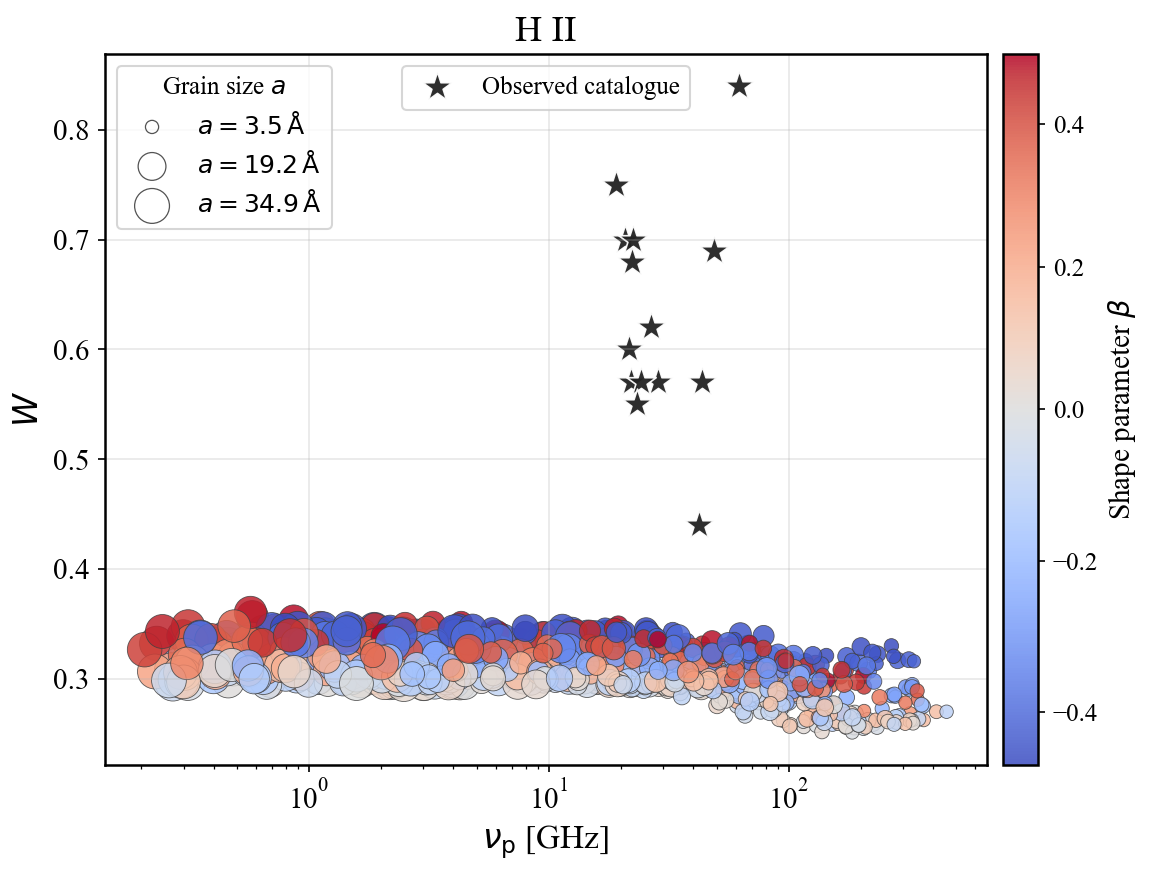

In [7]:
import matplotlib.colors as mcolors

Num=1000

grain_sizes = HII_params_tumbling[:Num, -2]  # typically the sampled grain size a
beta_values = HII_params_tumbling[:Num, -1]   # typically the shape parameter beta

size_min = grain_sizes.min()
size_max = grain_sizes.max()

size_span = size_max - size_min if size_max > size_min else 1.0

size_min_area = 40.0
size_max_area = 280.0

def _marker_area(values):
    values = np.asarray(values)
    fraction = (values - size_min) / size_span
    scaled = np.clip(fraction, 0.0, 1.0) ** 0.8  # soften the dynamic range
    return size_min_area + (size_max_area - size_min_area) * scaled

marker_sizes = _marker_area(grain_sizes)

if np.any(beta_values < 0) and np.any(beta_values > 0):
    norm = mcolors.TwoSlopeNorm(vmin=beta_values.min(), vcenter=0.0, vmax=beta_values.max())
else:
    norm = mcolors.Normalize(vmin=beta_values.min(), vmax=beta_values.max())

fig, ax = plt.subplots(figsize=(8, 6))

scatter = ax.scatter(
    HII_features_tumbling[:Num, 0],
    HII_features_tumbling[:Num, 1],
    c=beta_values,
    cmap="coolwarm",
    norm=norm,
    s=marker_sizes,
    alpha=0.85,
    edgecolors="0.25",
    linewidth=0.4
)

# scatter_no_tumbling = ax.scatter(
#     HII_features_no_tumbling[:Num, 0],
#     HII_features_no_tumbling[:Num, 1],
#     c="lightgray",
#     norm=norm,
#     s=marker_sizes,
#     alpha=0.85,
#     edgecolors="0.25",
#     linewidth=0.4
# )

obs_handle = ax.scatter(
    HII_catalogue[:, 0],
    HII_catalogue[:, 1],
    marker="*",
    s=220,
    c="#222222",
    edgecolors="white",
    linewidth=0.8,
    alpha=0.95,
    label="Observed catalogue"
)

ax.set_xlabel(r"$\nu_{\rm p}$ [GHz]", fontsize=16)
ax.set_ylabel(r"$W$", fontsize=16)
ax.set_xscale("log")
ax.grid(True, alpha=0.3)
ax.tick_params(axis="both", which="both", labelsize=14)

cbar = plt.colorbar(scatter, ax=ax, pad=0.015)
cbar.set_label(r"Shape parameter $\beta$", fontsize=14)
cbar.ax.tick_params(labelsize=12)

size_labels = np.linspace(size_min, size_max, 3)
size_handles = [
    ax.scatter([], [], s=_marker_area(val), facecolors="none", edgecolors="0.25", linewidth=0.6, alpha=0.9,
               label=fr"$a = {val*1e8:.1f}\,\mathrm{{\AA}}$")
    for val in size_labels
]

legend1 = ax.legend(
    handles=size_handles,
    title=r"Grain size $a$",
    loc="upper left",
    frameon=True,
    fontsize=12,
    title_fontsize=12
)
ax.add_artist(legend1)

legend2 = ax.legend([obs_handle], ["Observed catalogue"], loc="upper center", frameon=True, fontsize=12)

ax.set_title("H II", fontsize=18)
plt.savefig("Hii_catalogue_single.pdf")


plt.tight_layout()
plt.show()

In [8]:
# X=HII_params_no_tumbling
import copy

# Get indices where peak frequencies are larger than 5GHz.
X = copy.deepcopy(HII_params_tumbling)
Y= copy.deepcopy(HII_features_tumbling)

mask = (Y[:, 0] > 10) & (Y[:, 0] < 100)
idx = np.where(mask)[0]
print(f"Selected {len(idx)} samples out of {X.shape[0]} based on peak frequency criteria.")

X=X[idx, :]
Y=Y[idx, :]

Num=5000
X=X[:Num, :]
Y=Y[:Num, :]


from gsa_pipeline import gsa_pipeline
# Reload the module to get latest changes
import importlib
importlib.reload(sys.modules['gsa_pipeline'])
from gsa_pipeline import gsa_pipeline


# Your arrays
# X: (N_samples, N_params)
# Y: (N_samples, 2)  # columns: [peak_frequency, width]
param_names = ["nh","T","Chi","xh","xC","y","a","beta"]  # adjust to your order

out = gsa_pipeline(
    X, Y,
    feature_names=["nu_peak", "width"],
    param_names=param_names,
    scaler="standard",            # try "minmax" or None as well
    kernel_kind="rbf",             # try "rbf", "matern32", "matern52", "rq"
    ard=True,
    length_scale_init=1.0,        # or np.ones(d_kept) after dropping consts (handled internally)
    enable_perm=True,
    enable_gp=True,
    enable_sobol=True,
    make_pdp=True,
    N_sobol=1024,                 # increase for tighter Sobol CIs
    drop_const_atol=0.0,
    topk_pdp=3,
    pdp_prefix="pdp_demo",
    gp_random_state=0,
)

table_peak  = out["results"]["nu_peak"]["table"]
table_width = out["results"]["width"]["table"]

Selected 38006 samples out of 100000 based on peak frequency criteria.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [9]:
from gsa_pipeline import gsa_pipeline
# Reload the module to get latest changes
import importlib
importlib.reload(sys.modules['gsa_pipeline'])
from gsa_pipeline import sensitivity_table_to_latex

In [10]:
print(sensitivity_table_to_latex(table_peak, feature_label="peak"))

\begin{tabular}{llrrrrrrrrrr}
\toprule
Feature & Parameter & MI & dCor & PermMean & PermStd & S1 & S1_conf & ST & ST_conf & 1/ARD_LS & AggRank \\
\midrule
\multirow{7}{*}{peak} & a & 0.475 & 0.553 & 2.401 & 0.050 & 0.872 & 0.085 & 0.969 & 0.083 & 0.848 & 1.200 \\
 & nh & 0.000 & 0.018 & 1.228 & 0.044 & 0.037 & 0.030 & 0.099 & 0.019 & 4.292 & 3.200 \\
 & beta & 0.000 & 0.048 & 0.121 & 0.006 & 0.009 & 0.016 & 0.028 & 0.005 & 0.339 & 3.400 \\
 & Chi & 0.000 & 0.020 & 0.118 & 0.008 & 0.001 & 0.014 & 0.022 & 0.003 & 0.386 & 4.000 \\
 & xC & 0.000 & 0.034 & -0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.010 & 4.900 \\
 & T & 0.000 & 0.015 & 0.001 & 0.000 & -0.000 & 0.003 & 0.001 & 0.000 & 0.021 & 5.400 \\
 & xh & 0.000 & 0.019 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.010 & 5.900 \\
\bottomrule
\end{tabular}



In [11]:
print(sensitivity_table_to_latex(table_width, feature_label="width"))

\begin{tabular}{llrrrrrrrrrr}
\toprule
Feature & Parameter & MI & dCor & PermMean & PermStd & S1 & S1_conf & ST & ST_conf & 1/ARD_LS & AggRank \\
\midrule
\multirow{7}{*}{width} & beta & 0.958 & 0.443 & 1.477 & 0.049 & 0.560 & 0.068 & 0.702 & 0.068 & 0.577 & 1.400 \\
 & a & 0.153 & 0.280 & 0.483 & 0.017 & 0.187 & 0.054 & 0.389 & 0.049 & 0.895 & 2.000 \\
 & nh & 0.046 & 0.086 & 0.088 & 0.005 & -0.004 & 0.030 & 0.105 & 0.016 & 5.988 & 3.000 \\
 & Chi & 0.030 & 0.122 & 0.111 & 0.006 & 0.013 & 0.023 & 0.060 & 0.011 & 0.522 & 3.600 \\
 & T & 0.000 & 0.020 & 0.000 & 0.000 & 0.002 & 0.003 & 0.001 & 0.000 & 0.020 & 5.700 \\
 & xh & 0.006 & 0.039 & -0.000 & 0.000 & -0.000 & 0.000 & 0.000 & 0.000 & 0.010 & 5.900 \\
 & xC & 0.000 & 0.020 & -0.000 & 0.000 & -0.000 & 0.000 & 0.000 & 0.000 & 0.010 & 6.400 \\
\bottomrule
\end{tabular}



In [9]:
# Get indices where peak frequencies are larger than 5GHz.
X = copy.deepcopy(HII_params_no_tumbling)
Y= copy.deepcopy(HII_features_no_tumbling)

mask = (Y[:, 0] > 10) & (Y[:, 0] < 100)
idx = np.where(mask)[0]
print(f"Selected {len(idx)} samples out of {X.shape[0]} based on peak frequency criteria.")

X=X[idx, :]
Y=Y[idx, :]

Num=5000
X=X[:Num, :]
Y=Y[:Num, :]


from gsa_pipeline import gsa_pipeline
# Reload the module to get latest changes
import importlib
importlib.reload(sys.modules['gsa_pipeline'])
from gsa_pipeline import gsa_pipeline


# Your arrays
# X: (N_samples, N_params)
# Y: (N_samples, 2)  # columns: [peak_frequency, width]
param_names = ["nh","T","Chi","xh","xC","y","a","beta"]  # adjust to your order

out = gsa_pipeline(
    X, Y,
    feature_names=["nu_peak", "width"],
    param_names=param_names,
    scaler="standard",            # try "minmax" or None as well
    kernel_kind="rbf",             # try "rbf", "matern32", "matern52", "rq"
    ard=True,
    length_scale_init=1.0,        # or np.ones(d_kept) after dropping consts (handled internally)
    enable_perm=True,
    enable_gp=True,
    enable_sobol=True,
    make_pdp=True,
    N_sobol=1024,                 # increase for tighter Sobol CIs
    drop_const_atol=0.0,
    topk_pdp=3,
    pdp_prefix="pdp_demo",
    gp_random_state=0,
)

table_peak  = out["results"]["nu_peak"]["table"]
table_width = out["results"]["width"]["table"]
print(table_peak.round(4))
print(table_width.round(4))

Selected 38195 samples out of 100000 based on peak frequency criteria.
          MI    dCor  PermMean  PermStd    ARD_LS      S1  S1_conf      ST  \
a     0.5237  0.5899    2.6186   0.0696    1.3999  0.9254   0.0904  0.9706   
nh    0.0094  0.0345    1.2081   0.0388    0.1753  0.0288   0.0185  0.0717   
Chi   0.0000  0.0248    0.1006   0.0054    2.5704  0.0060   0.0110  0.0159   
beta  0.0036  0.0255    0.0635   0.0025    7.8675  0.0067   0.0099  0.0151   
T     0.0041  0.0183    0.0041   0.0004   39.3415  0.0005   0.0036  0.0017   
xC    0.0081  0.0269   -0.0001   0.0002  100.0000  0.0001   0.0003  0.0000   
xh    0.0059  0.0159    0.0000   0.0002  100.0000  0.0001   0.0003  0.0000   

      ST_conf  1/ARD_LS  AggRank  
a      0.0781    0.7143      1.2  
nh     0.0200    5.7050      1.8  
Chi    0.0031    0.3890      4.2  
beta   0.0024    0.1271      4.4  
T      0.0002    0.0254      5.2  
xC     0.0000    0.0100      5.3  
xh     0.0000    0.0100      5.9  
          MI    dCor  Pe

## Ensemble effect

In [10]:
import numpy as np
from scipy.stats import gaussian_kde
from tqdm.auto import tqdm

def monte_carlo_ensemble(params, data, p_target=None, q_sample=None, N_ensemble=10, alpha=1.0, show_progress=True):
    """
    Compute multiple ensemble integrals over saved samples using random weights.

    Parameters
    ----------
    params : np.ndarray, shape (N_samples, 3)
        Sample points in the 3D parameter space.
    data : np.ndarray, shape (N_samples, N_data)
        Function values at the sample points.
    p_target : callable or None
        Target probability density function p(theta). If None, uniform is assumed.
    q_sample : callable or None
        Sampling PDF q(theta). If None, KDE is used to estimate it.
    N_ensemble : int
        Number of ensemble realizations to generate.
    alpha : float
        Concentration parameter for the Dirichlet draw.
    show_progress : bool
        If True, display a tqdm progress bar for the ensemble loop.

    Returns
    -------
    ensemble_integrals : np.ndarray, shape (N_ensemble, N_data)
        Array of ensemble-integrated data.
    """
    params = np.asarray(params)
    data = np.asarray(data)
    N_samples = len(params)
    
    if N_samples == 0:
        raise ValueError("monte_carlo_ensemble received zero samples.")
    
    # If p_target not provided, assume uniform
    if p_target is None:
        p_vals = np.ones(N_samples)
    else:
        p_vals = np.asarray(p_target(params))
    
    # If q_sample not provided, estimate via KDE
    if q_sample is None:
        kde = gaussian_kde(params.T)
        q_vals = kde(params.T)
    else:
        q_vals = np.asarray(q_sample(params))
    
    if np.any(q_vals <= 0):
        raise ValueError("Sampling PDF q(theta) must be strictly positive on the provided samples.")
    
    # Base importance weights
    base_weights = p_vals / q_vals
    base_weights = np.clip(base_weights, 0.0, None)
    weight_sum = np.sum(base_weights)
    if weight_sum == 0:
        raise ValueError("All importance weights are zero; cannot form ensemble.")
    base_weights /= weight_sum
    
    positive_mask = base_weights > 0
    dirichlet_alpha = base_weights[positive_mask] * alpha
    if dirichlet_alpha.size == 0:
        raise ValueError("No positive weights remain after filtering; cannot draw from Dirichlet.")
    
    ensemble_integrals = []
    iterator = tqdm(range(N_ensemble), desc="Sampling ensembles", leave=False, disable=not show_progress)
    for _ in iterator:
        random_weights = np.zeros_like(base_weights)
        random_weights[positive_mask] = np.random.dirichlet(dirichlet_alpha)
        weighted_sum = np.sum(random_weights[:, None] * data, axis=0)
        ensemble_integrals.append(weighted_sum)
    
    return np.array(ensemble_integrals)

### Grain and env ensemble

In [19]:
# Get indices where peak frequencies are larger than 5GHz.
params_idx = [0,6,7] # columns corresponding to x_C, a, beta

Y = HII_features_tumbling
mask = (Y[:, 0] > 5) & (Y[:, 0] < 100)
sample_idx = np.where(mask)[0]
print(f"Selected {len(sample_idx)} samples out of {Y.shape[0]} based on peak frequency criteria.")



filtered_X = copy.deepcopy(HII_params_tumbling[sample_idx][:, params_idx] )
filtered_Y= copy.deepcopy(HII_sed_tumbling[sample_idx, :])

Selected 49049 samples out of 100000 based on peak frequency criteria.


In [20]:
SED_ensemble_0 = monte_carlo_ensemble(filtered_X, filtered_Y, p_target=None, N_ensemble=2000, alpha=0.05)
SED_ensemble_features_alpha_0 = fit_sed_ensemble(
    freqs,
    SED_ensemble_0,
    thres=1e-3, 
    v2=False
)
SED_ensemble_features_alpha_0[:, 0] = np.exp(SED_ensemble_features_alpha_0[:, 0])

100%|██████████| 2000/2000 [00:00<00:00, 5686.32it/s]                  


In [21]:
SED_ensemble_1 = monte_carlo_ensemble(filtered_X, filtered_Y, p_target=None, N_ensemble=2000, alpha=0.1)
SED_ensemble_features_alpha_1 = fit_sed_ensemble(
    freqs,
    SED_ensemble_1,
    thres=1e-3, 
    v2=False
)
SED_ensemble_features_alpha_1[:, 0] = np.exp(SED_ensemble_features_alpha_1[:, 0])


100%|██████████| 2000/2000 [00:00<00:00, 5551.41it/s]                  


In [22]:
SED_ensemble_2 = monte_carlo_ensemble(filtered_X, filtered_Y, p_target=None, N_ensemble=2000, alpha=1.0)
SED_ensemble_features_alpha_2 = fit_sed_ensemble(
    freqs,
    SED_ensemble_2,
    thres=1e-3, 
    v2=False
)
SED_ensemble_features_alpha_2[:, 0] = np.exp(SED_ensemble_features_alpha_2[:, 0])


100%|██████████| 2000/2000 [00:00<00:00, 4550.89it/s]                  


In [23]:
SED_ensemble_3 = monte_carlo_ensemble(filtered_X, filtered_Y, p_target=None, N_ensemble=2000, alpha=10.0)
SED_ensemble_features_alpha_3 = fit_sed_ensemble(
    freqs,
    SED_ensemble_3,
    thres=1e-3, 
    v2=False
)
SED_ensemble_features_alpha_3[:, 0] = np.exp(SED_ensemble_features_alpha_3[:, 0])

100%|██████████| 2000/2000 [00:00<00:00, 3872.60it/s]                  


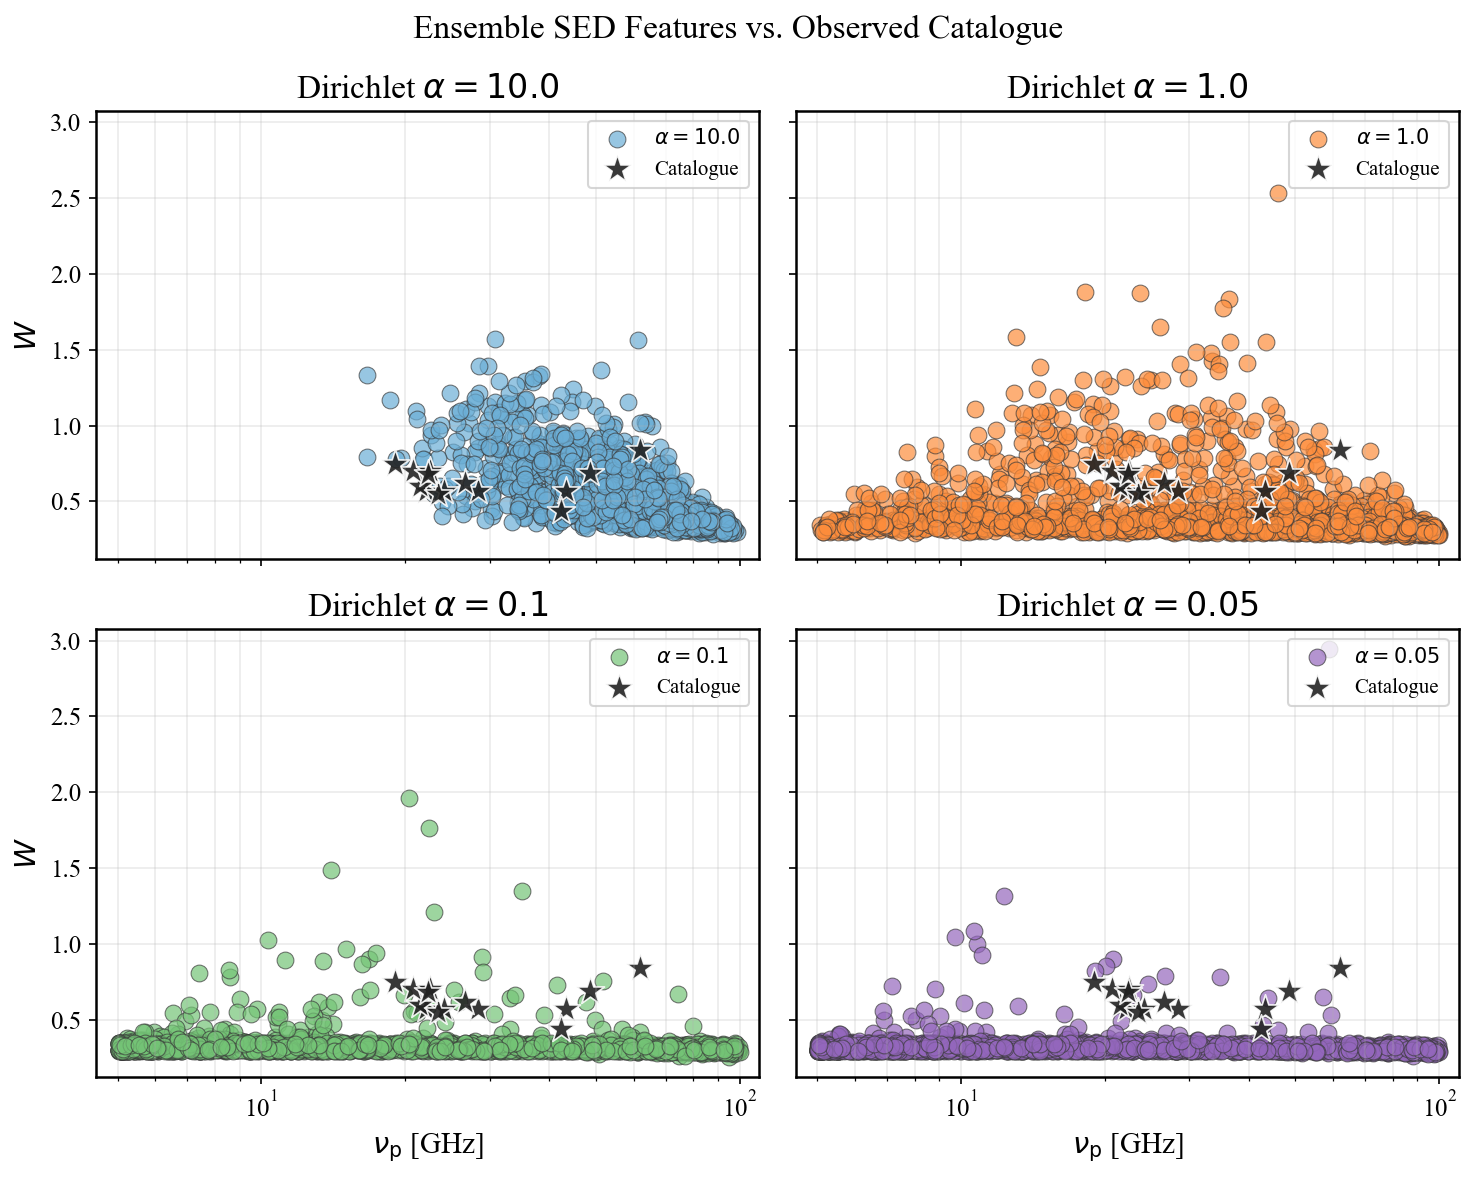

In [24]:
import matplotlib.pyplot as plt

alpha_sets = [
    (10.0, SED_ensemble_features_alpha_3),
    (1.0, SED_ensemble_features_alpha_2),
    (0.1, SED_ensemble_features_alpha_1),
    (0.05, SED_ensemble_features_alpha_0)
]

# Pre-compute shared limits for consistent axes
catalogue_x, catalogue_y = HII_catalogue[:, 0], HII_catalogue[:, 1]
all_features = np.vstack([feat for _, feat in alpha_sets])
x_min = min(all_features[:, 0].min(), catalogue_x.min())
x_max = max(all_features[:, 0].max(), catalogue_x.max())
y_min = min(all_features[:, 1].min(), catalogue_y.min())
y_max = max(all_features[:, 1].max(), catalogue_y.max())

palette = ["#6baed6", "#fd8d3c", "#74c476", "#9467bd"]
obs_kwargs = dict(
    marker="*",
    s=200,
    c="#222222",
    edgecolors="white",
    linewidth=0.8,
    alpha=0.9
)

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.flatten()

for ax, (alpha_val, features), color in zip(axes, alpha_sets, palette):
    ax.scatter(
        features[:, 0],
        features[:, 1],
        s=65,
        alpha=0.7,
        linewidth=0.5,
        edgecolors="#3a3a3a",
        facecolors=color,
        label=fr"$\alpha = {alpha_val}$"
)
    ax.scatter(catalogue_x, catalogue_y, label="Catalogue", **obs_kwargs)
    ax.set_xscale("log")
    ax.set_xlim(x_min * 0.9, x_max * 1.1)
    ax.set_ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
    ax.grid(True, which="both", alpha=0.25)
    ax.set_title(fr"Dirichlet $\alpha = {alpha_val}$")
    ax.legend(loc="upper right", fontsize=10, frameon=True)

for ax in axes[::2]:
    ax.set_ylabel(r"$W$")
for ax in axes[-2:]:
    ax.set_xlabel(r"$\nu_{\rm p}$ [GHz]")

fig.suptitle("Ensemble SED Features vs. Observed Catalogue", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 1])
plt.show()

In [ ]:
def p_target_fixed_env(theta):
    """
    Target PDF that fixes environmental parameters (nh, T, Chi, xh) to specific values.
    Only varies grain parameters (xC, y, a, beta).
    """

    xC_fixed = 2e-4
    # beta_fixed = 0.0
    
    # theta = np.asarray(theta)
    # mask = (
    #     (np.abs(theta[:, 0] - nh_fixed) < 1e-3) &
    #     (np.abs(theta[:, 1] - T_fixed) < 1e-3) &
    #     (np.abs(theta[:, 2] - Chi_fixed) < 1e-3) &
    #     (np.abs(theta[:, 3] - xh_fixed) < 1e-7)
    # )

    mask = np.abs(theta[:, 2] - xC_fixed) < 1e-4
    p_vals = np.where(mask, 1.0, 0.0)
    return p_vals

In [18]:
SED_grain_ensemble_0 = monte_carlo_ensemble(filtered_X, filtered_Y, p_target=None, N_ensemble=2000, alpha=0.05)
SED_grain_ensemble_features_alpha_0 = fit_sed_ensemble(
    freqs,
    SED_grain_ensemble_0,
    thres=1e-3, 
    v2=False
)
SED_grain_ensemble_features_alpha_0[:, 0] = np.exp(SED_grain_ensemble_features_alpha_0[:, 0])

SED_grain_ensemble_1 = monte_carlo_ensemble(filtered_X, filtered_Y, p_target=None, N_ensemble=2000, alpha=0.1)
SED_grain_ensemble_features_alpha_1 = fit_sed_ensemble(
    freqs,
    SED_grain_ensemble_1,
    thres=1e-3, 
    v2=False
)
SED_grain_ensemble_features_alpha_1[:, 0] = np.exp(SED_grain_ensemble_features_alpha_1[:, 0])

SED_grain_ensemble_2 = monte_carlo_ensemble(filtered_X, filtered_Y, p_target=None, N_ensemble=2000, alpha=1.0)
SED_grain_ensemble_features_alpha_2 = fit_sed_ensemble(
    freqs,
    SED_grain_ensemble_2,
    thres=1e-3, 
    v2=False
)
SED_grain_ensemble_features_alpha_2[:, 0] = np.exp(SED_grain_ensemble_features_alpha_2[:, 0])

SED_grain_ensemble_3 = monte_carlo_ensemble(filtered_X, filtered_Y, p_target=None, N_ensemble=2000, alpha=10.0)
SED_grain_ensemble_features_alpha_3 = fit_sed_ensemble(
    freqs,
    SED_grain_ensemble_3,
    thres=1e-3, 
    v2=False
)
SED_grain_ensemble_features_alpha_3[:, 0] = np.exp(SED_grain_ensemble_features_alpha_3[:, 0])

100%|██████████| 2000/2000 [00:00<00:00, 4675.90it/s]                  


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

alpha_sets = [
    (10.0, SED_grain_ensemble_features_alpha_3),
    (1.0, SED_grain_ensemble_features_alpha_2),
    (0.1, SED_grain_ensemble_features_alpha_1),
    (0.05, SED_grain_ensemble_features_alpha_0)
]

# Pre-compute shared limits for consistent axes
catalogue_x, catalogue_y = HII_catalogue[:, 0], HII_catalogue[:, 1]
all_features = np.vstack([feat for _, feat in alpha_sets])
x_min = min(all_features[:, 0].min(), catalogue_x.min())
x_max = max(all_features[:, 0].max(), catalogue_x.max())
y_min = min(all_features[:, 1].min(), catalogue_y.min())
y_max = max(all_features[:, 1].max(), catalogue_y.max())

palette = ["#6baed6", "#fd8d3c", "#74c476", "#9467bd"]
obs_kwargs = dict(
    marker="*",
    s=200,
    c="#222222",
    edgecolors="white",
    linewidth=0.8,
    alpha=0.9
)

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.flatten()

for ax, (alpha_val, features), color in zip(axes, alpha_sets, palette):
    ax.scatter(
        features[:, 0],
        features[:, 1],
        s=65,
        alpha=0.7,
        linewidth=0.5,
        edgecolors="#3a3a3a",
        facecolors=color,
        label=fr"$\alpha = {alpha_val}$"
)
    ax.scatter(catalogue_x, catalogue_y, label="Catalogue", **obs_kwargs)
    ax.set_xscale("log")
    ax.set_xlim(x_min * 0.9, x_max * 1.1)
    ax.set_ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
    ax.grid(True, which="both", alpha=0.25)
    ax.set_title(fr"Dirichlet $\alpha = {alpha_val}$")
    ax.legend(loc="upper right", fontsize=10, frameon=True)

for ax in axes[::2]:
    ax.set_ylabel(r"$W$")
for ax in axes[-2:]:
    ax.set_xlabel(r"$\nu_{\rm p}$ [GHz]")

fig.suptitle("Ensemble SED Features vs. Observed Catalogue", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 1])
plt.show()
